# Modelo de Kermack McKendrick

In [1]:
include("Taylor.jl")
using ADT
using PyPlot

Las ecuaciones diferenciales que rigen el modelo para una especie son:

$$ \frac{dS}{dt} = -\beta SI$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.

En este modelo NO tomamos en cuenta los nacimientos y muertes, así que para una población fija se tiene que $ N = S(t) + I(t) + R(t)$ en todo tiempo.

In [2]:
function coefs_1(gamma, beta, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) # F1 = -b*S*I
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) # F2 = g*I

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1 (generic function with 2 methods)

Error absoluto

In [3]:
eps_abs = 1e-50

1.0e-50

In [3]:
function paso(a::Taylor, p = 40)
    
    while p != 0 && a.pol[p] == 0
       p = p-1;
    end
    
    h = 0.5*(eps_abs/abs(a.pol[p]))^(1/p)
end

paso (generic function with 2 methods)

In [4]:
function ev_horner{T<:Number}(a::Taylor,t0::T)
    
    n = gradomax(a)
    x1 = a.pol[n]
    
    for k = 1:n-1
        x1 = a.pol[n-k] + x1*t0
    end
    return x1
end

ev_horner (generic function with 1 method)

In [6]:
function integrador_kermack(N, I0, R0, t0, tf, gamma, beta)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_1(gamma, beta, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    return t,s,i,r
end

integrador_kermack (generic function with 1 method)

In [9]:
N = 1.
infectados_iniciales = N/1000
recuperados_iniciales = 0.0
t_inicial = 0.
t_final = 160.
beta = 0.2
gamma = 0.1

@time t,s,i,r = integrador_kermack(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta);
length(t)

  1.257153 seconds (43.30 M allocations: 697.051 MB, 3.79% gc time)


123

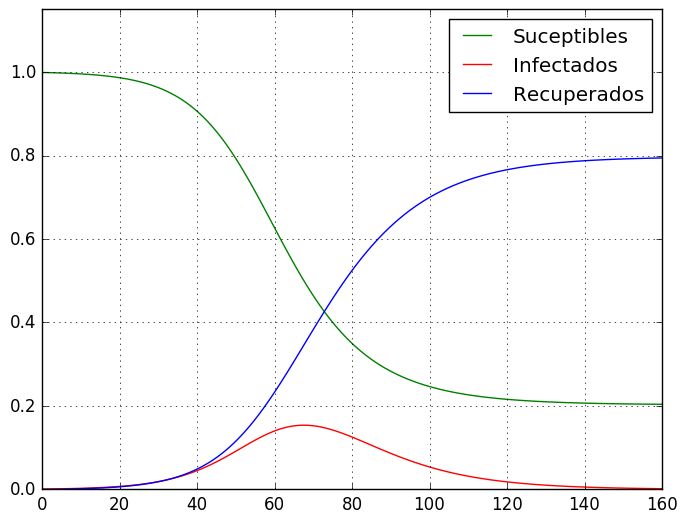

In [10]:
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
axis([0,160,0,1.15])
grid()
legend()
show()

Ahora hagamos un diagrama fase de esto, donde no esperamos ningún comportamiento peculiar.

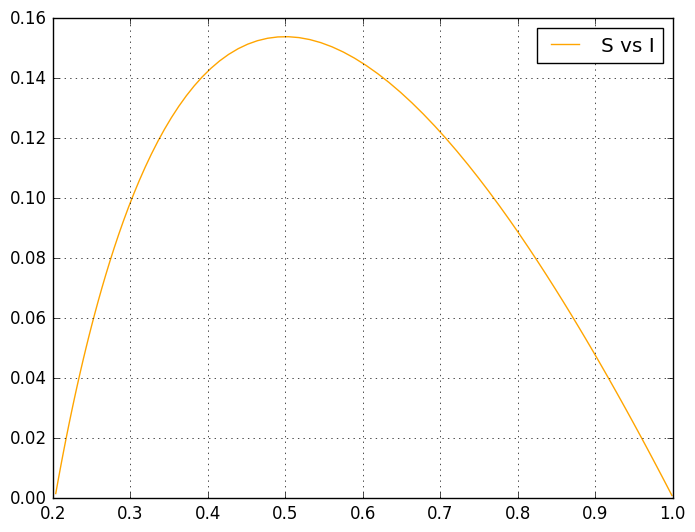

In [11]:
plot(s,i, color = "orange", label = "S vs I")
legend()
grid()
show()

Ahora introducimos un término de reincidencia $\phi$, quedando las ecuaciones como:

$$ \frac{dS}{dt} = -\beta SI + \phi R$$
$$ \frac{dI}{dt} = \beta SI - \gamma I $$
$$ \frac{dR}{dt} = \gamma I -\phi R$$
Como sigue, definimos nuestras funciones de coeficientes y el integrador.

In [12]:
function coefs_1_re(gamma, beta, phi, S0, I0, R0, n = 40)
    s = [S0]
    i = [I0]
    r = [R0]
    
    
    F1(S,I) = beta*S*I
    F2(I) = gamma*I
    F3(R) = phi*R
    for k = 1:n
       
        
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)
        
        fs = -F1(Ts,Ti) + F3(Tr)# F1 = -b*S*I + p*R
        fi = F1(Ts, Ti) - F2(Ti)
        fr = F2(Ti) - F3(Tr) # F2 = g*I-p*R

        S0 = fs.pol[k]/k
        I0 = fi.pol[k]/k
        R0 = fr.pol[k]/k
        
        push!(s,S0)
        push!(r,R0)
        push!(i,I0)
    end
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    return s,i,r
        
end

coefs_1_re (generic function with 2 methods)

In [13]:
function integrador_kermack_re(N, I0, R0, t0, tf, gamma, beta, phi)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    n_iteraciones = 1
    while t0 < tf && n_iteraciones < 10000
        
        S,I,R = coefs_1_re(gamma, beta, phi, S0, I0, R0)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
        n_iteraciones += 1
    end
    return t,s,i,r
end

integrador_kermack_re (generic function with 1 method)

Establecemos condiciones iniciales e integramos.

In [17]:
N = 1.
t_inicial = 0.
t_final = 1400.
beta = .5
gamma = .25
phi = 0.005
infectados_iniciales = N/1000
recuperados_iniciales = 0.

@time t,s,i,r = integrador_kermack_re(N, infectados_iniciales, recuperados_iniciales, t_inicial, t_final, gamma, beta, phi);
length(t)

  8.721034 seconds (227.70 M allocations: 3.661 GB, 3.14% gc time)


639

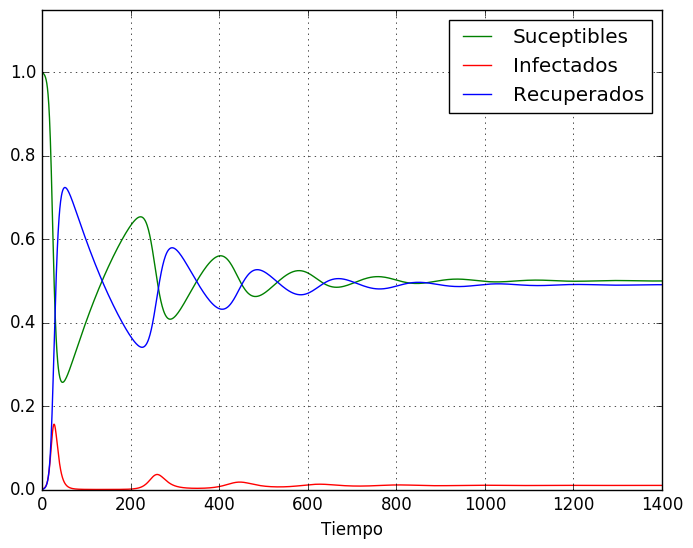

In [16]:
plot(t,s, color = "green", label = "Suceptibles")
plot(t,i, color = "red", label = "Infectados")
plot(t,r, color = "blue", label = "Recuperados")
axis([0,t_final,0,1.15])
grid()
legend()
xlabel("Tiempo")
show()

Dibujamos ahora el diagrama fase.

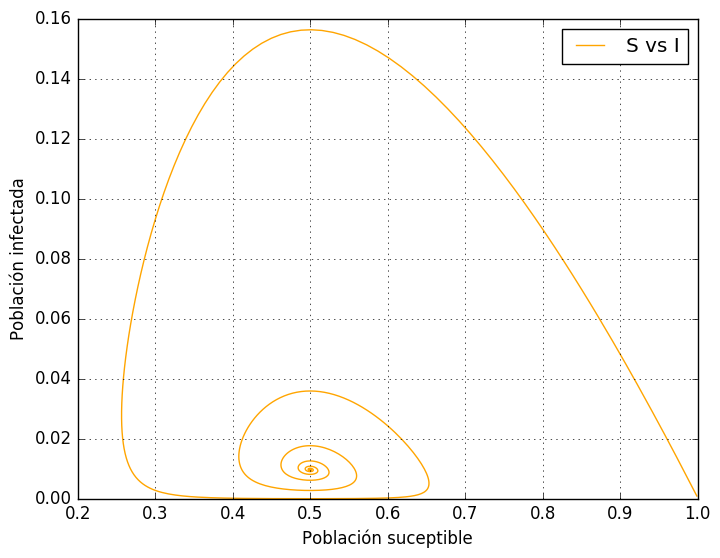

In [18]:
plot(s,i, color = "orange", label = "S vs I")
legend()
xlabel("Población suceptible")
ylabel("Población infectada")
grid()
show()

**Animación de la Solución**

Al inicial el programa debe ejecutar 2 veces la celda; la primera vez da error y la segunda muestra el video. El usar PyCall también interfiere con Pyplot asíque podría limpiarse el namespace para que no interfiriese con las celdas de abajo.

In [33]:
using PyCall
@pyimport matplotlib.animation as anim

In [35]:
tdata=t
xdata=s
ydata=i
#Use External Viewer for Animation
pygui(true)


#Construct Figure and Plot Data
fig = figure()
ax = axes(xlim = (minimum(xdata),maximum(xdata)),ylim=(minimum(ydata),maximum(ydata)))
global line1 = ax[:plot]([],[],"r-")[1]
global p1 = ax[:plot]([],[],"or")[1]

function init()
    global line1
    line1[:set_data]([],[])
    p1[:set_data]([],[])
    return (line1,p1)
end

step=min(1,length(tdata))
function animate(i)
    k = i + 1
    global line1    
    line1[:set_data](xdata[max(1,step*(k-50)):(step*k)],ydata[max(1,step*(k-50)):(step*k)])#grafica una linea con 50 ptos previos
    p1[:set_data]([xdata[step*k]],ydata[step*k])#grafica sólo el punto actual
    return (line1,p1)
end

#Call the animator.
myanim = anim.FuncAnimation(fig, animate, init_func=init, frames=ifloor(length(tdata)/step), interval=20)

#This will require ffmpeg or equivalent.
myanim[:save]("test.mp4", bitrate=-1, extra_args=["-vcodec", "libx264", "-pix_fmt", "yuv420p"])

# Function for creating an embedded video given a filename
function html_video(filename)
    base64_video = base64(open(readbytes, filename))
    """<video controls src="data:video/x-m4v;base64,$base64_video">"""
end

display("text/html", html_video("test.mp4"))

LoadError: LoadError: PyError (:PyObject_Call) <type 'exceptions.ValueError'>
ValueError(u'Cannot save animation: no writers are available. Please install mencoder or ffmpeg to save animations.',)
  File "C:\Users\Luis Villegas\Anaconda2\lib\site-packages\matplotlib\animation.py", line 789, in save
    raise ValueError("Cannot save animation: no writers are "

while loading In[35], in expression starting on line 34

# Model SIRS con Nacimientos y Muertes

Ahora consideraremos que hay una taza de natalidad $\mu$, la cual asumiremos que es igual a la taza de mortalidad. Además, consideraremos una tasa de reincidencia f de la población recuperada. De este modo, la población presenta el siguiente flujo:
$\mathcal{S} \rightarrow \mathcal{I} \rightarrow \mathcal{R} \rightarrow \mathcal{S}$, por lo que el modelo se denomina **SIRS** (donde además, consideramos los nacimientos y muertes). Entonces, el modelo queda de la siguiemte manera:

\begin{array}{rcl} 
\frac{dS}{dt}  & = & - \frac{\beta S I}{N} + \mu (N - S) + f R  \\ 
\frac{dI}{dt} & = & \frac{\beta S I}{N} - \gamma I - \mu I  \\
\frac{dR}{dt} & = & \gamma I - \mu R - f R \\
\end{array}

Ahora, realizaremos la integración de este sistema de ecuaciones. Sólo requeriremos modificar la función de coeficientes para considerar los términos adicionales y, además, modificar el integrador para que considere los parámetros adicionales.

In [19]:
function coefs_SIRS(γ,β,μ,f,S_0,I_0,R_0,n=50)
    N=S_0+I_0+R_0
    
    s=[S_0]
    i=[I_0]
    r=[R_0]  #inicializar arrays 
    
    F1(S,I,R) = -(β/N)*S*I + μ*(I+R)+f*R #N-S=I+R pues N=I+R+S 
    F2(S,I) = (β/N)*S*I -γ*I -μ*I
    F3(I,R) = γ*I-μ*R-f*R
    
    f1=Taylor(0) #inicializamos f's pues las variables definidas en el for son locales
    f2=Taylor(0)
    f3=Taylor(0)
    
    for k in 1:n
        Ts = Taylor(s)
        Ti = Taylor(i)
        Tr = Taylor(r)

        f1=F1(Ts,Ti,Tr)
        f2=F2(Ts,Ti)
        f3=F3(Ti,Tr)
        
        S_0 = f1.pol[k]/k
        I_0 = f2.pol[k]/k
        R_0 = f3.pol[k]/k
        
        push!(s,S_0)
        push!(r,R_0)
        push!(i,I_0)
           
    end
    
    s = Taylor(s)
    i = Taylor(i)
    r = Taylor(r)
    
    return s,i,r
end

coefs_SIRS (generic function with 2 methods)

In [20]:
"""
Esta función integra la ecuación diferencial del modelo de Kermack-McKendrick SIRS discurito previamente. Sus parámetros son:
integrador_kermack(N=población total,I0=infectados inicialmente,t0=tiempo inicial,tf=tiempo final,γ=tasa de recuperación,
β=tasa de infección,μ=tasa de natalidad,f=tasa,n=numero de términos en los pols. de Taylor). 
Se consideran nacimientos y muertes, pero se asume que la tasa de natalidad es igual que la de mortalidad. Con esto,
la población total se mantiene constante
"""
function integrador_kermack_SIRS(N, I0, R0, t0, tf, gamma, beta,mu,f,n=50)
    S0 = N - I0 - R0
    
    t = [t0]
    s = [S0]
    i = [I0]
    r = [R0]
    
    while t0 < tf
        
        S,I,R = coefs_SIRS(gamma, beta,mu,f, S0, I0, R0,n)
        
        h_s = paso(S)
        h_i = paso(I)
        h_r = paso(R)
        h = min(h_s, h_i, h_r)
        
        t0 += h
        
        S0 = ev_horner(S,h)
        I0 = ev_horner(I,h)
        R0 = ev_horner(R,h)
        
        push!(t,t0)
        push!(s,S0)
        push!(i,I0)
        push!(r,R0)
    end
    
    return t,s,i,r
end

integrador_kermack_SIRS (generic function with 2 methods)

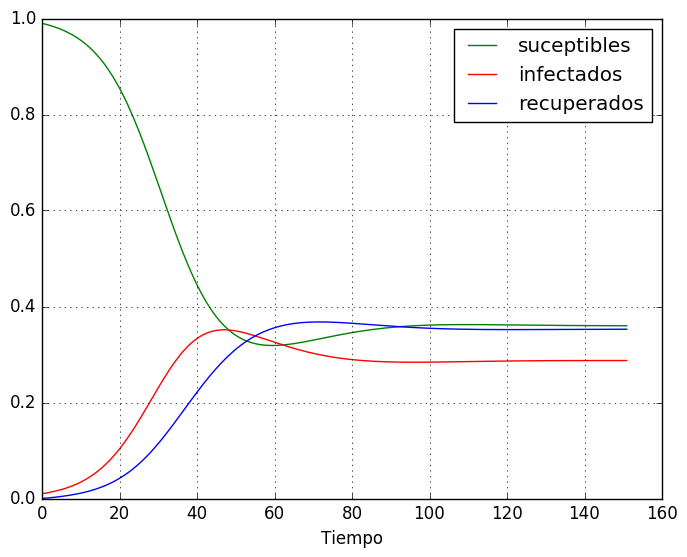

  3.226316 seconds (88.40 M allocations: 1.441 GB, 3.70% gc time)


In [21]:
N = 1.
I0 = N/100
R0 = 0.
S0 = N-I0-R0
ti = 0.
tf = 150.
beta = 0.2
gamma = 0.07
mu = 0.002
f = 0.055

@time t,s,i,r = integrador_kermack_SIRS(N, I0, R0, ti, tf, gamma, beta ,mu,f);

plot(t,s, color = "green", label = "suceptibles")
plot(t,i, color = "red", label = "infectados")
plot(t,r, color = "blue", label = "recuperados")
grid()
xlabel("Tiempo")
legend()
show()

  3.476824 seconds (94.26 M allocations: 1.526 GB, 3.60% gc time)
  3.629763 seconds (90.80 M allocations: 1.470 GB, 3.57% gc time)
  3.462160 seconds (88.72 M allocations: 1.437 GB, 3.52% gc time)
  3.662840 seconds (87.33 M allocations: 1.414 GB, 3.52% gc time)
  3.364978 seconds (85.95 M allocations: 1.392 GB, 3.40% gc time)


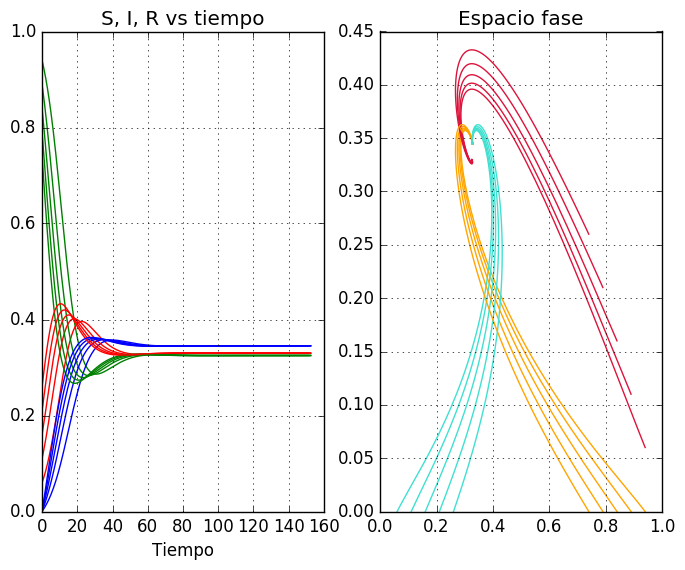

In [25]:
p = 5

for j in 1:p
    
    N = 1.
    I0 = N/100+0.05*j
    R0 = 0.
    S0 = N-I0-R0
    ti = 0.
    tf = 150.
    beta = 0.28
    gamma = 0.09
    mu = 0.001
    f = 0.085


    @time t,s,i,r = integrador_kermack_SIRS(N, I0, R0, ti, tf, gamma, beta, mu, f);

    subplot(1,2,1)
    plot(t,s, color = "green", label = "Suceptibles")
    plot(t,i, color = "red", label = "Infectados")
    plot(t,r, color = "blue", label = "Recuperados")
    grid()
    title("S, I, R vs tiempo")
    xlabel("Tiempo")
    
    subplot(1,2,2)
    plot(s,i, color="crimson")
    plot(s,r,color="orange")
    plot(i,r,color="turquoise")
    grid()
    title("Espacio fase")
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
end

# Para K especies (K=3)

Para un sistema de $K$ especies, el modelo se vuelve

$$ \frac{dS_i}{dt} = -\sum_{j = 1}^K \beta_{ij} S_iI_j$$
$$ \frac{dI_i}{dt} = \sum_{j = 1}^K\beta_{ij} S_iI_j - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$
donde $S$ es el número de individuos suceptibles, $I$ el de individuos infectados y $R$ el de recuperados; así como $\beta$ es la tasa de transmisión de la infección y $\gamma$ la tasa de recuperación de la especie.


$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i $$

In [24]:
eps_abs = 1e-20

1.0e-20

In [29]:
function coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fr = F2(gamma[i], Ti[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

coefs_3 (generic function with 2 methods)

In [30]:
function k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    
    while t0 < tf
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3(gamma, beta, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
    end
    return t,s,i,r
end

k_3 (generic function with 1 method)

Integramos ahora con condiciones iniciales y en un intervalo de tiempo razonable.

In [31]:
N1 = .5
N2 = .3
N3 = .2
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 250.
;

In [35]:
beta = rand(3,3)/3
gamma = rand(3)/8
;

In [36]:
@time t3, s3, i3, r3 = k_3(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma, beta);

  1.766407 seconds (45.13 M allocations: 735.920 MB, 3.71% gc time)


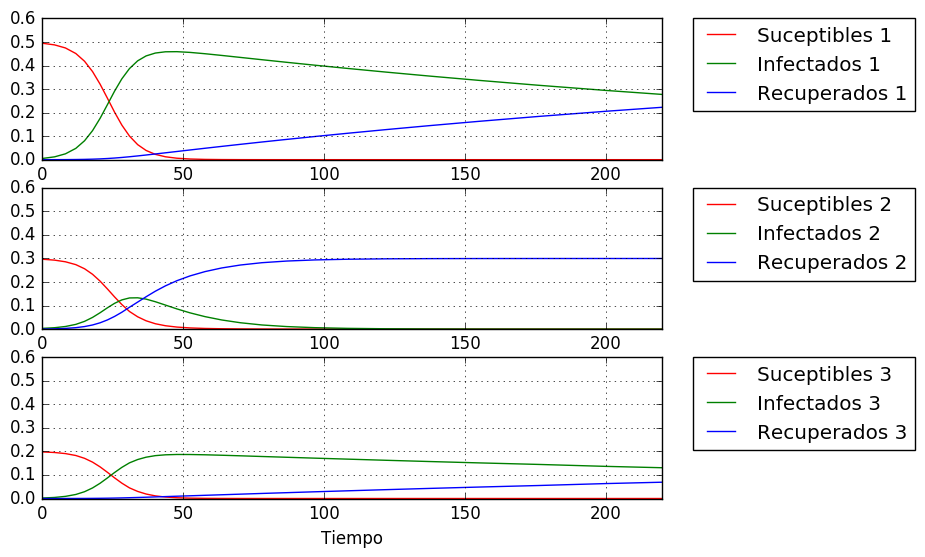

In [37]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    axis([0, 220, 0, 0.6])
    grid()
end
xlabel("Tiempo")
show()

In [38]:
suma = 0
for k = 1:3
    suma += s3[k]+i3[k]+r3[k]
end
dump(suma)

Array(Float64,(31,)) [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0  …  1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]


Como vemos, la población total $N$ se mantiene constante.

Ahora que nuestro integrador funciona, complicamos las cosas e implementaremos un factor de reincidencia $\phi$ para cada una de las especies.

$$ \frac{dS_i}{dt} = -\beta_{i1} S_iI_1 - \beta_{i2} S_iI_2 - \beta_{i3} S_iI_3 + \phi_i R_i$$
$$ \frac{dI_i}{dt} = \beta_{i1} S_iI_1 + \beta_{i2} S_iI_2 + \beta_{i3} S_iI_3 - \gamma_i I_i $$
$$ \frac{dR_i}{dt} = \gamma_i I_i - \phi_i R_i$$

Modificamos un poco nuestro código anterior para lograrlo. Definimos una función para calcular los coeficientes y nuestro integrador.

In [5]:
function coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, n = 40)
       
    S = Array{Array{Float64,1},1}();
    push!(S,[S0_1])
    push!(S,[S0_2])
    push!(S,[S0_3])
    I = Array{Array{Float64,1},1}();
    push!(I,[I0_1])
    push!(I,[I0_2])
    push!(I,[I0_3])
    R = Array{Array{Float64,1},1}();
    push!(R,[R0_1])
    push!(R,[R0_2])
    push!(R,[R0_3])
        
    F1(beta_ij,S,I) = -beta_ij*S*I
    F2(gamma_i,I) = gamma_i*I
    F3(phi_i,R) = phi_i*R
    
    for k = 1:n-1
        Ts = [Taylor(S[j]) for j in 1:3]
        Ti = [Taylor(I[j]) for j in 1:3]
        Tr = [Taylor(R[j]) for j in 1:3]
        
        for i = 1:3
            fs = 0
            fi = 0
            fr = 0
            
            for j = 1:3
                fs += F1(beta[i,j],Ts[i],Ti[j])
            end
            fs += F3(phi[i],Tr[i])
            fr = F2(gamma[i], Ti[i])-F3(phi[i],Tr[i])
            fi = -fs - fr
            
        
            S0 = fs.pol[k]/k
            I0 = fi.pol[k]/k
            R0 = fr.pol[k]/k

            push!(S[i], S0)
            push!(I[i], I0)
            push!(R[i], R0)
        end
    end
    s = [Taylor(S[i]) for i in 1:3]
    i = [Taylor(I[i]) for i in 1:3]
    r = [Taylor(R[i]) for i in 1:3]
    return s,i,r
end

coefs_3_reincidencia (generic function with 2 methods)

In [6]:
function k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, t0, tf, gamma, beta, phi)
    S0_1 = N1 - I0_1 - R0_1
    S0_2 = N2 - I0_2 - R0_2
    S0_3 = N3 - I0_3 - R0_3
        
    
    t = [t0]
    s = Array{Array{Float64,1},1}();
    push!(s,[S0_1])
    push!(s,[S0_2])
    push!(s,[S0_3])
    i = Array{Array{Float64,1},1}();
    push!(i,[I0_1])
    push!(i,[I0_2])
    push!(i,[I0_3])
    r = Array{Array{Float64,1},1}();
    push!(r,[R0_1])
    push!(r,[R0_2])
    push!(r,[R0_3])
    
    matriz_de_paso = zeros(3)
    n_iteracion = 1
    
    while t0 < tf && n_iteracion < 2000
        S0_1 = s[1][end]
        S0_2 = s[2][end]
        S0_3 = s[3][end]
        
        I0_1 = i[1][end]
        I0_2 = i[2][end]
        I0_3 = i[3][end]
        
        R0_1 = r[1][end]
        R0_2 = r[2][end]
        R0_3 = r[3][end]
        
        S,I,R = coefs_3_reincidencia(gamma, beta, phi, S0_1, S0_2, S0_3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3)
        
        for k in 1:3

            h_s = paso(S[k])
            h_i = paso(I[k])
            h_r = paso(R[k])
            h = min(h_s, h_i, h_r)
            
            matriz_de_paso[k] = h

            S0 = ev_horner(S[k],h)
            I0 = ev_horner(I[k],h)
            R0 = ev_horner(R[k],h)
        
            push!(s[k],S0)
            push!(i[k],I0)
            push!(r[k],R0)
        end
        t0 += min(matriz_de_paso...)
        push!(t, t0)
        
        n_iteracion += 1
    end
    return t,s,i,r
end

k_3_reincidencia (generic function with 1 method)

Definimos nuestras matrices de coeficientes. $\beta_{ij}$ es la matriz de coeficientes de transmisión, $\gamma_i$ la de coeficientes de recuperación (con $1/\gamma_i$ el tiempo promedio de recuperación) y $\phi_i$ la matriz de reincidencia o re-contagio. Al no tener datos experimentales, tomamos valores que están de acuerdo con la teoría.

In [44]:
# Hacemos 3 matrices de prueba con valores pre-establecidos.

phi1 = ([0.011980782470983145,0.0122242866833574,0.12049916741165438])
gamma1 = ([0.0920466,0.0690204,0.0427661])
beta1 = [0.138933 0.0147811 0.0747647; 0.0243735 0.116977 0.0574383; 0.183494 0.109088 0.283322]
;

In [7]:
# Tomamos valores aleatorios para nuestros parámetros.

beta = rand(3,3)/3
gamma = rand(3)/11
phi = rand(3)/80
;

Definimos ahora valores iniciales y el intervalo de tiempo para que nuestro integrador pueda operar.

In [50]:
N1 = 1.
N2 = 1.
N3 = 1.
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 700.
;

In [51]:
@time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, gamma1, 
beta1, phi);
length(t3)

  2.737444 seconds (86.11 M allocations: 1.392 GB, 4.39% gc time)


58

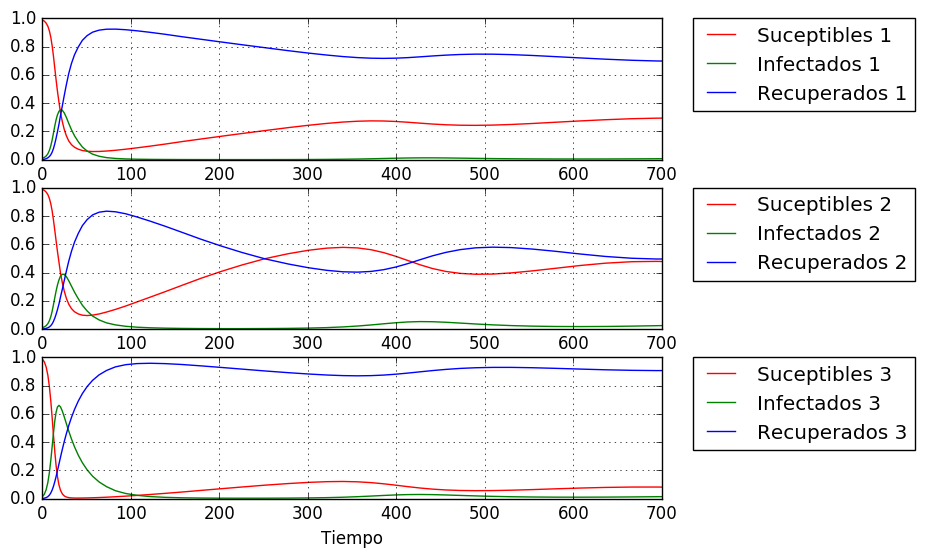

In [52]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    axis([0,tiempo_final, 0, 1])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end
xlabel("Tiempo")
show()

Muchos diagramas de fase a lo tonto.

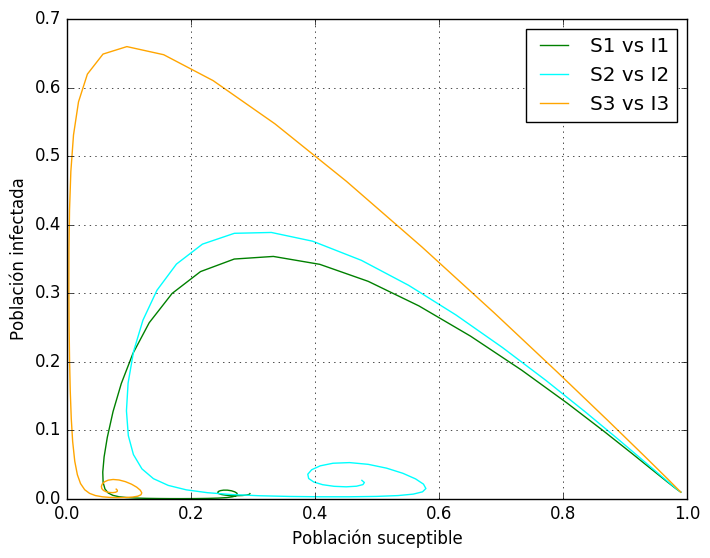

In [53]:
plot(s3[1],i3[1], color = "green", label = "S1 vs I1")
# plot(s3[1],i3[2], color = "red", label = "S1 vs I2")
# plot(s3[1],i3[3], color = "blue", label = "S1 vs I3")
plot(s3[2],i3[2], color = "cyan", label = "S2 vs I2")
# plot(s3[2],i3[3], color = "magenta", label = "S2 vs I3")
plot(s3[3],i3[3], color = "orange", label = "S3 vs I3")
# plot(r3[1],i3[1], color = "peru", label = "R3 vs I3")
legend()
grid()
xlabel("Población suceptible")
ylabel("Población infectada")
show()

Ahora queremos empezar a ver la dinámica si perturbamos las condiciones iniciales. Como ejemplo ilustrativo, lo haremos sobre la población 1 de nuestro problema anterior. Declaramos de nuevo nuestros parámetros.

In [17]:
N1 = 1.
N2 = 1.
N3 = 1.
I0_1 = N1/100
I0_2 = N2/100
I0_3 = N3/100
R0_1 = 0.
R0_2 = 0.
R0_3 = 0.
tiempo_inicial = 0.
tiempo_final = 450.
;

Ahora variamos la condición inicial para ver cómo se comporta el sistema.

  2.532846 seconds (78.55 M allocations: 1.270 GB, 5.76% gc time)
  2.517829 seconds (78.55 M allocations: 1.270 GB, 5.73% gc time)
  2.474109 seconds (77.04 M allocations: 1.245 GB, 5.71% gc time)
  3.257089 seconds (77.04 M allocations: 1.245 GB, 5.50% gc time)
  3.300604 seconds (77.04 M allocations: 1.245 GB, 4.84% gc time)
  3.278660 seconds (77.04 M allocations: 1.245 GB, 4.95% gc time)
  3.613387 seconds (77.04 M allocations: 1.245 GB, 5.12% gc time)
  3.801424 seconds (75.53 M allocations: 1.221 GB, 4.32% gc time)
  3.093629 seconds (75.53 M allocations: 1.221 GB, 4.70% gc time)
  3.161605 seconds (75.53 M allocations: 1.221 GB, 4.78% gc time)
  3.204230 seconds (75.53 M allocations: 1.221 GB, 4.92% gc time)
  3.360569 seconds (75.53 M allocations: 1.221 GB, 4.84% gc time)
  3.910261 seconds (74.02 M allocations: 1.197 GB, 4.76% gc time)
  3.099768 seconds (74.02 M allocations: 1.197 GB, 4.73% gc time)
  3.012059 seconds (74.02 M allocations: 1.197 GB, 4.64% gc time)
  2.982014

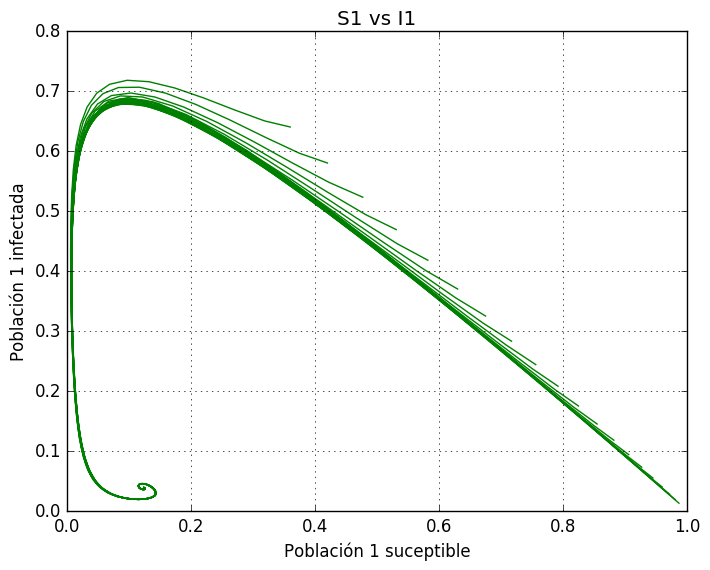

  2.949163 seconds (72.51 M allocations: 1.172 GB, 4.60% gc time)


In [71]:
for i in 1:20
    I0_1 += 0.003*i
    @time t3, s3, i3 = k_3_reincidencia(N1, N2, N3, I0_1, I0_2, I0_3, R0_1, R0_2, R0_3, tiempo_inicial, tiempo_final, 
    Gamma, Beta, Phi);    
    plot(s3[1],i3[1], color = "green")
end
grid()
title("S1 vs I1")
xlabel("Población 1 suceptible")
ylabel("Población 1 infectada")
show()

... no parece muy interesante. ¿Qué pasará ahora si perturbamos el sistema de equilibrio?
Sabemos que el sistema de ecuaciones diferenciales para el modelo tiene como solución de equilibrio la trivial, pero el modelo permite una solución de equilibrio no nula: a esta le llamamos la solución de *equilibrio endémico*. Utilizamos la paquetería externa NLsolve para encontrar estos puntos de equilibrio endémico.

In [12]:
using NLsolve

In [18]:
# Tomamos valores aleatorios para nuestros parámetros.

beta = rand(3,3)/3
gamma = rand(3)/10
phi = rand(3)/450
;

In [19]:
Beta = [0.134526   0.0449375  0.283664; 0.0322725  0.319525   0.253701; 0.282935   0.239162   0.113143]
Gamma = [0.0465392; 0.0549394; 0.0497149]
Phi = [0.00212581; 0.00188398; 0.00152644]
;

$x[1,2,3,4,5,6,7,8,9] = (S1,S2,S3,I1,I2,I3,R1,R2,R3) $

In [54]:
function soluciones!(x, svec)
    svec[1] = 0
    svec[2] = 0
    svec[3] = 0
    ### Para S1, S2, S3
    for j = 1:3
        for k = 1:3
            svec[j] += -beta_1[j,k]*x[j]*x[k+3]
        end
    svec[j] += phi_1[j]*x[j+6]
    end
    ### Para R1, R2, R3
    for j = 1:3
        svec[j+6] = gamma_1[j]*x[j+3]-phi_1[j]*x[j+6]
    end
    ### Para I1, I2, I3
    svec[4] = N1-x[1]-x[4]-x[7]
    svec[5] = N2-x[2]-x[5]-x[8]
    svec[6] = N3-x[3]-x[6]-x[9]
end

soluciones! (generic function with 1 method)

In [55]:
x_inicial = 0.3*ones(9)
resultados = nlsolve(soluciones!,x_inicial)

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3]
 * Zero: [0.1338879795167064,0.019002774193362867,0.10042512441172173,0.12005514508383607,0.03390608055816082,0.07472443753296855,0.7460568753994575,0.9470911452484763,0.8248504380553098]
 * Inf-norm of residuals: 0.000000
 * Iterations: 5
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 6
 * Jacobian Calls (df/dx): 6

In [56]:
S_estable_1 = resultados.zero[1]
S_estable_2 = resultados.zero[2]
S_estable_3 = resultados.zero[3]
I_estable_1 = resultados.zero[4]
I_estable_2 = resultados.zero[5]
I_estable_3 = resultados.zero[6]
R_estable_1 = resultados.zero[7]
R_estable_2 = resultados.zero[8]
R_estable_3 = resultados.zero[9]
tiempo_inicial = 0.
tiempo_final = 2500.
;

In [57]:
@time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_estable_1, I_estable_2, 
I_estable_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
gamma_1, beta_1, phi_1);

  5.598922 seconds (132.94 M allocations: 2.149 GB, 4.65% gc time)


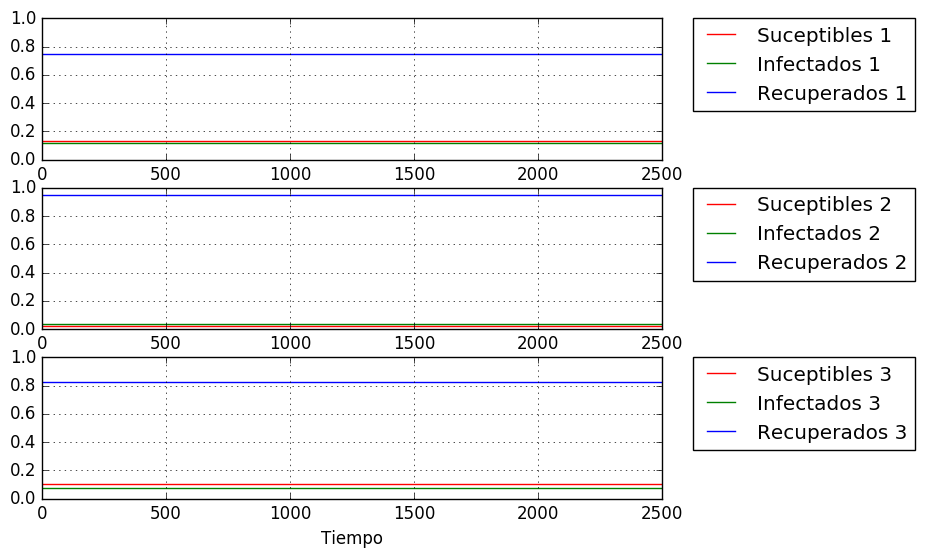

In [58]:
for k = 1:3
    subplot(3,1,k)
    plot(t3, s3[k], color = "red", label = "Suceptibles $k")
    plot(t3, i3[k], color = "green", label = "Infectados $k")
    plot(t3, r3[k], color = "blue", label = "Recuperados $k")
    axis([0,tiempo_final, 0, 1])
    legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    grid()
end
xlabel("Tiempo")
show()

Ahora perturbamos las condiciones iniciales (para todas las poblaciones infectadas) y vemos cómo se comporta el sistema.

  0.718962 seconds (21.15 M allocations: 350.075 MB, 6.08% gc time)
  1.256169 seconds (37.77 M allocations: 625.134 MB, 5.52% gc time)
  1.501348 seconds (40.79 M allocations: 675.144 MB, 6.30% gc time)
  1.391234 seconds (42.30 M allocations: 700.149 MB, 6.12% gc time)
  2.007225 seconds (43.81 M allocations: 725.154 MB, 4.36% gc time)
  1.914519 seconds (45.32 M allocations: 750.159 MB, 4.80% gc time)
  1.963582 seconds (46.83 M allocations: 775.164 MB, 5.03% gc time)
  2.071220 seconds (48.34 M allocations: 800.174 MB, 5.29% gc time)


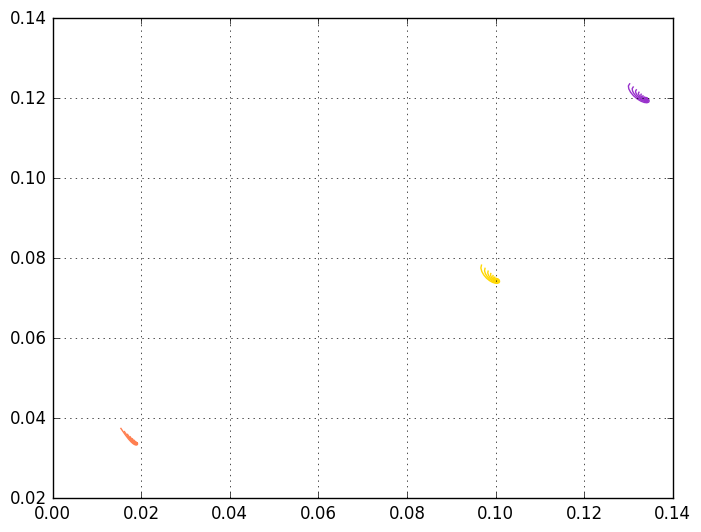

  2.328685 seconds (49.85 M allocations: 825.179 MB, 5.05% gc time)


In [59]:
eps_abs = 1e-30

I_perturbado_1 = I_estable_1
I_perturbado_2 = I_estable_2
I_perturbado_3 = I_estable_3
tiempo_inicial = 0.
tiempo_final = 500.

for i in 0:8
    I_perturbado_1 += 0.0001*i
    I_perturbado_2 += 0.0001*i
    I_perturbado_3 += 0.0001*i
    
    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
    gamma_1, beta_1, phi_1);  
    
    colores = ["darkorchid", "coral", "gold"]
    
    for k in 1:3
#     k = 1
        plot(s3[k],i3[k], color = colores[k])
    end
end
grid()
show()

  2.405718 seconds (63.45 M allocations: 1.026 GB, 6.35% gc time)
  3.155463 seconds (67.98 M allocations: 1.099 GB, 5.62% gc time)
  3.117790 seconds (72.51 M allocations: 1.172 GB, 5.45% gc time)
  3.321804 seconds (77.04 M allocations: 1.245 GB, 5.51% gc time)
  3.543852 seconds (80.07 M allocations: 1.294 GB, 5.31% gc time)
  3.935671 seconds (83.09 M allocations: 1.343 GB, 6.28% gc time)
  3.818737 seconds (86.11 M allocations: 1.392 GB, 5.50% gc time)
  3.830569 seconds (89.13 M allocations: 1.441 GB, 5.32% gc time)
  3.850404 seconds (92.15 M allocations: 1.490 GB, 5.19% gc time)
  3.987602 seconds (95.17 M allocations: 1.538 GB, 5.42% gc time)
  4.077186 seconds (98.19 M allocations: 1.587 GB, 5.35% gc time)
  4.230699 seconds (99.70 M allocations: 1.612 GB, 5.68% gc time)
  4.307864 seconds (102.72 M allocations: 1.661 GB, 5.37% gc time)
  4.359905 seconds (104.24 M allocations: 1.685 GB, 5.38% gc time)
  4.462771 seconds (107.26 M allocations: 1.734 GB, 5.32% gc time)
  4.525

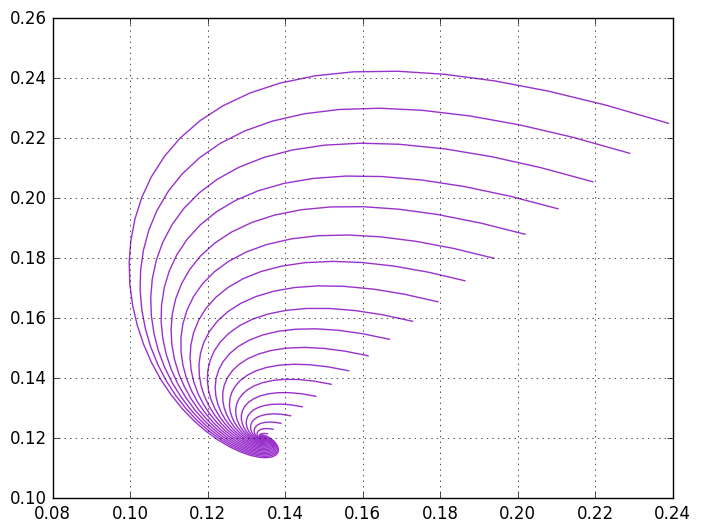

  4.891886 seconds (117.83 M allocations: 1.905 GB, 5.49% gc time)


In [68]:
eps_abs = 1e-39

I_perturbado_1 = I_estable_1
I_perturbado_2 = I_estable_2
I_perturbado_3 = I_estable_3

R_perturbado_1 = R_estable_1
R_perturbado_2 = R_estable_2
R_perturbado_3 = R_estable_3

for i in 1:20
    I_perturbado_1 += 0.0005*i
#     I_perturbado_2 += 0.005*i
#     I_perturbado_3 += 0.001*i
    
    R_perturbado_1 += -0.001*i
#     R_perturbado_2 += -0.005*i
#     R_perturbado_3 += -0.003*i
    

    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_perturbado_1, R_perturbado_2, R_perturbado_3,tiempo_inicial, tiempo_final, 
    gamma_1,beta_1,phi_1);  
    colores = ["darkorchid", "coral", "gold"]
    for k = 1:1
#         subplot(3,1,k)
        plot(s3[k],i3[k], color = colores[k])
    end
end
grid()
show()

In [47]:
for i in 1:7
    I_perturbado_1 += 0.001*i
    I_perturbado_2 += 0.005*i
    I_perturbado_3 += 0.01*i

    @time t3,s3,i3,r3 = k_3_reincidencia(N1, N2, N3, I_perturbado_1, I_perturbado_2, 
    I_perturbado_3, R_estable_1, R_estable_2, R_estable_3,tiempo_inicial, tiempo_final, 
    gamma, beta, phi);  

    colores = ["darkorchid", "coral", "gold"]
    plot(s3[1],i3[1], color = colores[1])
end
grid()
show()

LoadError: LoadError: UndefVarError: I_perturbado_1 not defined
while loading In[47], in expression starting on line 1

ESTO SE DESCONTROLÓ

Los parámetros de abajo son para las curvas de arriba, las delgaditas

In [49]:
gamma_1 = [0.0382117; 0.0378735; 0.0425732]
phi_1 = [0.00614901; 0.00135588; 0.00385677]
beta_1 = [0.159791  0.143463  0.136713; 0.330302  0.152469  0.304485; 0.160856  0.30528   0.0269721]
;